## Closed Loop Simulation Notebook

This notebook breaks down the closed loop simulation in different jupyter notebook cells. The aim of this notebook is to ease the debugging and development of the different packages involved in the Optical Feedback Control loop.

This notebook was last run on July 7th 2022. 
Details:
- Stack release: 2021_25, Last verified to run 2022-07-07
- ts_phosim release: v2.0.4


### Required python packages

In [1]:
import argparse
import copy
import logging
import numpy as np
import os
import shutil
import subprocess
import sys
import time
import batoid
from tqdm import tqdm

from lsst.ts.batoid.CloseLoopTask import CloseLoopTask
from lsst.ts.batoid.utils.PlotUtil import plotFwhmOfIters, returnFwhmOfIters
from lsst.daf import butler as dafButler
from lsst.ts.wep.Utility import CamType, FilterType
from lsst.ts.batoid.utils.Utility import getPhoSimPath, getAoclcOutputPath, getCamera
from lsst.ts.batoid.utils.SensorWavefrontError import SensorWavefrontError
from lsst.ts.batoid.wfsim.wfsim import SSTBuilder

from astropy.utils.data import get_pkg_data_filename
from astropy.io import fits
import matplotlib.pyplot as plt

# Set the parser
parser = argparse.ArgumentParser(
    description="Run AOS closed-loop simulation (default is amplifier files)."
)
parser = CloseLoopTask.setDefaultParser(parser)
parser = CloseLoopTask.setImgParser(parser)

# Get the default arguments
sys.argv = ['-f']
args = parser.parse_args()

logger = logging.getLogger()
logger.setLevel(args.log_level)

In [8]:
args.output = '/sdf/home/g/gmegias/aos/perturbations/test_altitudes_lut/'

# Initialize the ClosedLoopTask
closeLoopTask = CloseLoopTask()
os.environ["AOCLCOUTPUTPATH"] = "/sdf/home/g/gmegias/aos/ts_batoid/output/"
args.inst = 'comcam' 
args.boresightDeg = [0.03, -0.02]
args.eimage = None
args.skyFile = '/sdf/home/g/gmegias/aos/ts_batoid/tests/testData/sky/skyComCam.txt'
args.filterType = 'ref'

if os.path.exists(args.output):
    shutil.rmtree(args.output)

In [9]:
closeLoopTask.initializeRealLoop(args)

# Set observation Id
obsId = 9006000
azimuths = [12.3220459990762, 15.0207565212601, 12.4087798844556, 6.00423002223948, 9.8691145691411, 3.92082713429274, 358.213722189074, 353.491339690214, 358.554321047216, 359.308443473205]
altitudes_fixed = [27.0912,27.0912,27.0912,27.0912,27.0912,27.0912,27.0912,27.0912,27.0912,27.0912]
altitudes = [63.9233491559512, 61.680789774804, 59.187367550931, 58.8803169041516, 56.6817343864588, 56.2665557633179, 55.270873511614, 56.645540030316, 58.0584884234231, 60.8086785781179]

gqEffFwhm = 1
iterCount = 0

for idx in range(10):

    closeLoopTask.batoidCmpt.setSurveyParam(
        obsId=obsId,
        zAngleInDeg=altitudes[idx],
        rotAngInDeg=0.0
    )

    closeLoopTask.batoidCmpt.setZAngle()

    if idx > 0:
        closeLoopTask.batoidCmpt.applyLUT()


    gqEffFwhm, wfe, sensor_ids = closeLoopTask.fwhm_compute(idx, obsId, altitudes[idx], rotAngInDeg=0.0)
    print(gqEffFwhm)

    closeLoopTask.ofcCalc.calculate_corrections(
            wfe=wfe,
            field_idx=sensor_ids,
            filter_name=str('R'),
            gain=-1,
            rot=0.0,
        )
    dofInUm = closeLoopTask.ofcCalc.ofc_controller.aggregated_state 
    dofInUm_old = copy.deepcopy(dofInUm)

    closeLoopTask.batoidCmpt.setDofInUm(dofInUm)
    
    # Save the DOF file
    closeLoopTask.batoidCmpt.saveDofInUmFileForNextIter(dofInUm)

    # Add the observation ID by 10 for the next iteration
    obsId += 10


0.5347153269057773
0.46514768589577415
0.32659875135311817
0.3315719249191461
0.3203082261142625
0.3044959428238775
0.30149054663984104
0.2997848362404709
0.2986760426726136
0.30607960253385064


### Summarize the FWHM and plot results

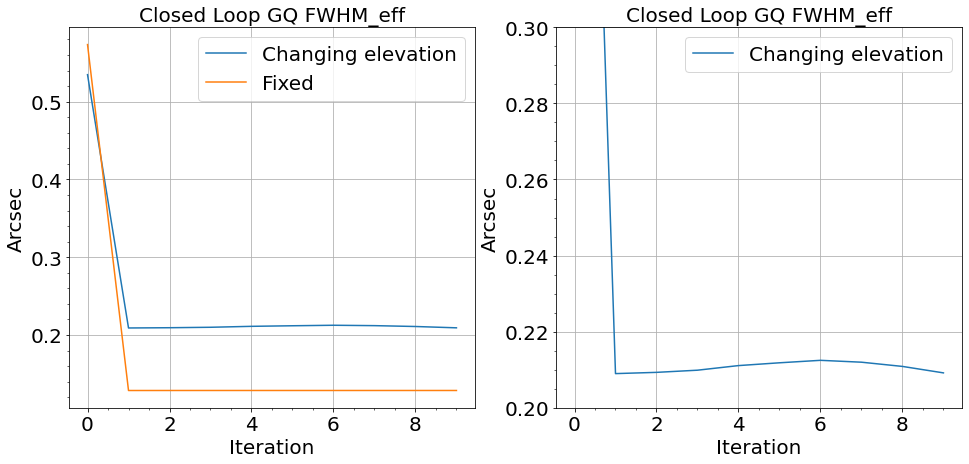

In [13]:
# Summarize the FWHM
fwhmItersFileName = "fwhmIters.png"
saveToFilePath = os.path.join(closeLoopTask.baseOutputDir, fwhmItersFileName)
reshapedFwhmData = returnFwhmOfIters('/sdf/home/g/gmegias/aos/perturbations/test_altitudes/',  10, saveToFilePath=saveToFilePath)


reshapedFwhmData_fixed = returnFwhmOfIters('/sdf/home/g/gmegias/aos/perturbations/test_fixed/', 10)


%matplotlib inline  
plt.figure(figsize = (16,7))
plt.subplot(1,2,1)
#plt.plot(reshapedFwhmData[:-1, :].T, "bx-")
plt.plot(reshapedFwhmData[-1, :], "-", label="Changing elevation")
plt.plot(reshapedFwhmData_fixed[-1, :], "-", label="Fixed")
plt.xlabel("Iteration", fontsize = 20)
plt.ylabel("Arcsec", fontsize = 20)
plt.minorticks_on()
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 20)
plt.title('Closed Loop GQ FWHM_eff', fontsize = 20)
plt.grid()

plt.subplot(1,2,2)
#plt.plot(reshapedFwhmData[:-1, :].T, "bx-")
plt.plot(reshapedFwhmData[-1, :], "-", label="Changing elevation")
plt.xlabel("Iteration", fontsize = 20)
plt.ylabel("Arcsec", fontsize = 20)
plt.minorticks_on()
plt.tick_params(labelsize = 20)
plt.ylim([0.2, 0.3])
plt.legend(fontsize = 20)
plt.title('Closed Loop GQ FWHM_eff', fontsize = 20)
plt.grid()

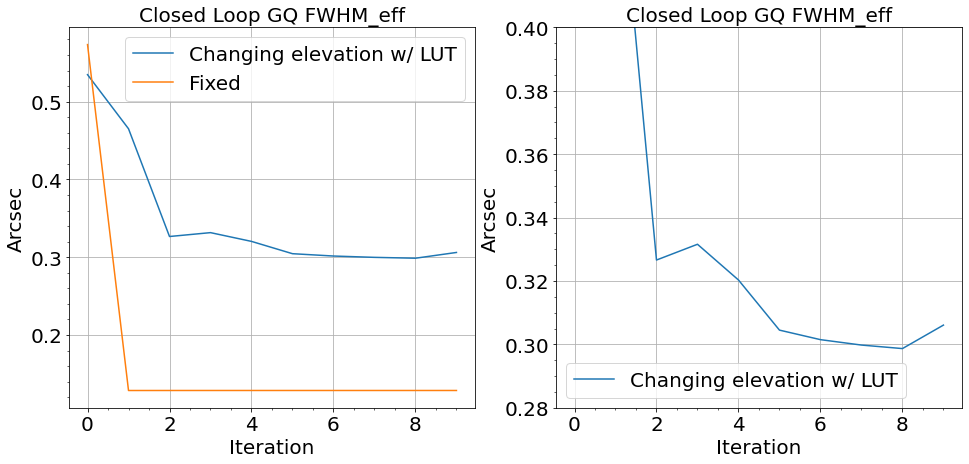

In [11]:
# Summarize the FWHM
fwhmItersFileName = "fwhmIters.png"
saveToFilePath = os.path.join(closeLoopTask.baseOutputDir, fwhmItersFileName)
reshapedFwhmData = returnFwhmOfIters('/sdf/home/g/gmegias/aos/perturbations/test_altitudes_lut/',  10, saveToFilePath=saveToFilePath)


reshapedFwhmData_fixed = returnFwhmOfIters('/sdf/home/g/gmegias/aos/perturbations/test_fixed/', 10)


%matplotlib inline  
plt.figure(figsize = (16,7))
plt.subplot(1,2,1)
#plt.plot(reshapedFwhmData[:-1, :].T, "bx-")
plt.plot(reshapedFwhmData[-1, :], "-", label="Changing elevation w/ LUT")
plt.plot(reshapedFwhmData_fixed[-1, :], "-", label="Fixed")
plt.xlabel("Iteration", fontsize = 20)
plt.ylabel("Arcsec", fontsize = 20)
plt.minorticks_on()
plt.tick_params(labelsize = 20)
plt.legend(fontsize = 20)
plt.title('Closed Loop GQ FWHM_eff', fontsize = 20)
plt.grid()

plt.subplot(1,2,2)
#plt.plot(reshapedFwhmData[:-1, :].T, "bx-")
plt.plot(reshapedFwhmData[-1, :], "-", label="Changing elevation w/ LUT")
plt.xlabel("Iteration", fontsize = 20)
plt.ylabel("Arcsec", fontsize = 20)
plt.minorticks_on()
plt.tick_params(labelsize = 20)
plt.ylim([0.28, 0.4])
plt.legend(fontsize = 20)
plt.title('Closed Loop GQ FWHM_eff', fontsize = 20)
plt.grid()

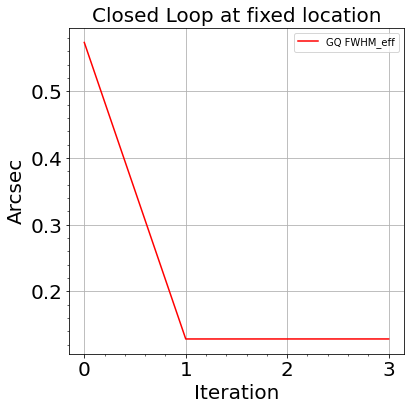

In [4]:
# Summarize the FWHM



%matplotlib inline  
plt.figure(figsize = (6,6))
#plt.plot(reshapedFwhmData[:-1, :].T, "bx-")
plt.plot(reshapedFwhmData[-1, :], "r-", label="GQ FWHM_eff")
plt.xlabel("Iteration", fontsize = 20)
plt.ylabel("Arcsec", fontsize = 20)
plt.minorticks_on()
plt.tick_params(labelsize = 20)
plt.legend()
plt.title('Closed Loop at fixed location', fontsize = 20)
plt.grid()
plt.show()